In [1]:
import xarray as xr
import icechunk
import boto3
import zarr

In [2]:
icechunk.__version__

'0.2.3'

In [3]:
zarr.config.set(
    {
        'threading.max_workers': 16,
        'async.concurrency': 32
    }
)

In [6]:
store_name = "2025-02-27/GPM_3IMERGHH.07-virtual-1998-v2"

session = boto3.Session()

# Get the credentials from the session
credentials = session.get_credentials()

# Extract the actual key, secret, and token
creds = credentials.get_frozen_credentials()
storage = icechunk.s3_storage(
    bucket='nasa-veda-scratch',
    prefix=f"icechunk/{store_name}",
    access_key_id=creds.access_key,
    secret_access_key=creds.secret_key,
    session_token=creds.token            
)

In [7]:
repo = icechunk.Repository.open(
    storage=storage,
)
repo

In [8]:
session = repo.readonly_session(branch="main")
store = session.store
store

In [9]:
import zarr
%time group = zarr.open_group(store, zarr_format=3, mode="r")
group

CPU times: user 250 µs, sys: 1.93 ms, total: 2.18 ms
Wall time: 1.68 ms


<Group <icechunk.store.IcechunkStore object at 0x7f8cd7b0e3c0>>

In [10]:
group.tree()

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


/
├── lat (1800,) float32
├── lat_bnds (1800, 2) float32
├── lon (3600,) float32
├── lon_bnds (3600, 2) float32
├── precipitation (17520, 3600, 1800) float32
├── precipitationQualityIndex (17520, 3600, 1800) float32
├── probabilityLiquidPrecipitation (17520, 3600, 1800) int16
├── randomError (17520, 3600, 1800) float32
├── time (17520,) int32
└── time_bnds (17520, 2) int32

In [11]:
%time _ = group['lat'][:]

CPU times: user 5.69 ms, sys: 0 ns, total: 5.69 ms
Wall time: 51.3 ms


In [12]:
%time _ = group['time'][:]

CPU times: user 4.52 ms, sys: 56 µs, total: 4.57 ms
Wall time: 46.6 ms


In [13]:
%time _ = group['lon'][:]

CPU times: user 3.99 ms, sys: 0 ns, total: 3.99 ms
Wall time: 18.7 ms


In [14]:
%time _ = group['precipitation'][0, 0, 0]

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 154 ms, sys: 56.8 ms, total: 211 ms
Wall time: 455 ms


In [15]:
%time _ = group['precipitation'][:100, 0, 0]

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 386 ms, sys: 81 ms, total: 467 ms
Wall time: 461 ms


In [16]:
%time _ = group['precipitation'][:1000, 0, 0]

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 3.61 s, sys: 502 ms, total: 4.11 s
Wall time: 3.31 s


In [17]:
# how fast is this?

chunk_size_raw_bytes = 145 * 1800 * 4
comp_ratio = 0.5
chunk_size_compressed_bytes = comp_ratio * chunk_size_raw_bytes
num_chunks = 1000
load_time = 2

total_bytes = num_chunks * chunk_size_compressed_bytes
throughput_gbps = total_bytes / load_time / 1e9
total_bytes, throughput_gbps

(522000000.0, 0.261)

In [18]:
%time _ = group['precipitation'][:1500, 0, 0]

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 5.52 s, sys: 764 ms, total: 6.28 s
Wall time: 3.48 s


In [20]:
%time _ = group['precipitation'][:10000, 0, 0]

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 35.8 s, sys: 4.45 s, total: 40.2 s
Wall time: 30.1 s


In [16]:
group['precipitation'].info

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


Type               : Array
Zarr format        : 3
Data type          : DataType.float32
Shape              : (17520, 3600, 1800)
Chunk shape        : (1, 145, 1800)
Order              : C
Read-only          : True
Store type         : IcechunkStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (Zlib(codec_name='numcodecs.zlib', codec_config={'level': 6}),)
No. bytes          : 454118400000 (422.9G)

In [17]:
group['precipitation'].info_complete()

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)

KeyboardInterrupt



In [19]:
%time _ = group['time'][:];

CPU times: user 5.77 ms, sys: 0 ns, total: 5.77 ms
Wall time: 64.5 ms


In [21]:
%time ds = xr.open_dataset(store, engine="zarr", consolidated=False, zarr_format=3, decode_coords="all")
ds

/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 2.33 s, sys: 159 ms, total: 2.48 s
Wall time: 2.82 s


<xarray.Dataset> Size: 2TB
Dimensions:                         (lat: 1800, lon: 3600, latv: 2, lonv: 2,
                                     time: 17520, nv: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
    lat_bnds                        (lat, latv) float32 14kB ...
    lon_bnds                        (lon, lonv) float32 29kB ...
  * time                            (time) object 140kB 1998-01-01 00:00:00 ....
    time_bnds                       (time, nv) object 280kB ...
Dimensions without coordinates: latv, lonv, nv
Data variables:
    probabilityLiquidPrecipitation  (time, lon, lat) float32 454GB ...
    randomError                     (time, lon, lat) float32 454GB ...
    precipitation                   (time, lon, lat) float32 454GB ...
    precipitationQualityIndex       (time, lon, lat) float32 454GB ...
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

In [22]:
result = ds.precipitation.sel(lon=-92.05, lat=34.95, method="nearest").sel(time='1998-01')
result

<xarray.DataArray 'precipitation' (time: 1488)> Size: 6kB
[1488 values with dtype=float32]
Coordinates:
    lat      float32 4B 34.95
    lon      float32 4B -92.05
  * time     (time) object 12kB 1998-01-01 00:00:00 ... 1998-01-31 23:30:00
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...

In [23]:
%time result.load()

CPU times: user 5.44 s, sys: 620 ms, total: 6.06 s
Wall time: 4.39 s


<xarray.DataArray 'precipitation' (time: 1488)> Size: 6kB
array([0.        , 0.        , 0.        , ..., 0.72999996, 0.        ,
       0.        ], dtype=float32)
Coordinates:
    lat      float32 4B 34.95
    lon      float32 4B -92.05
  * time     (time) object 12kB 1998-01-01 00:00:00 ... 1998-01-31 23:30:00
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...

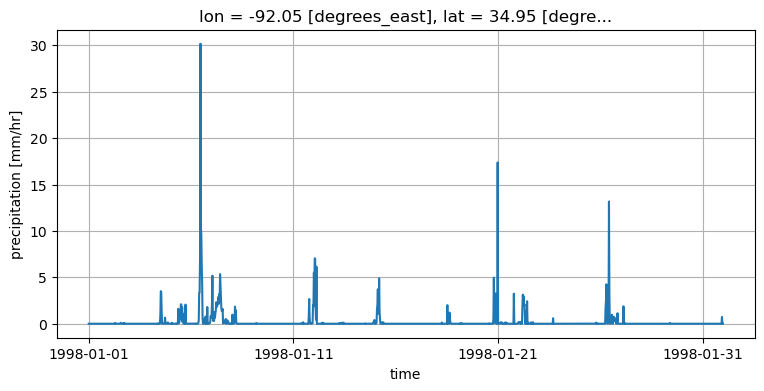

In [37]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
result.plot(ax=ax)
ax.grid()


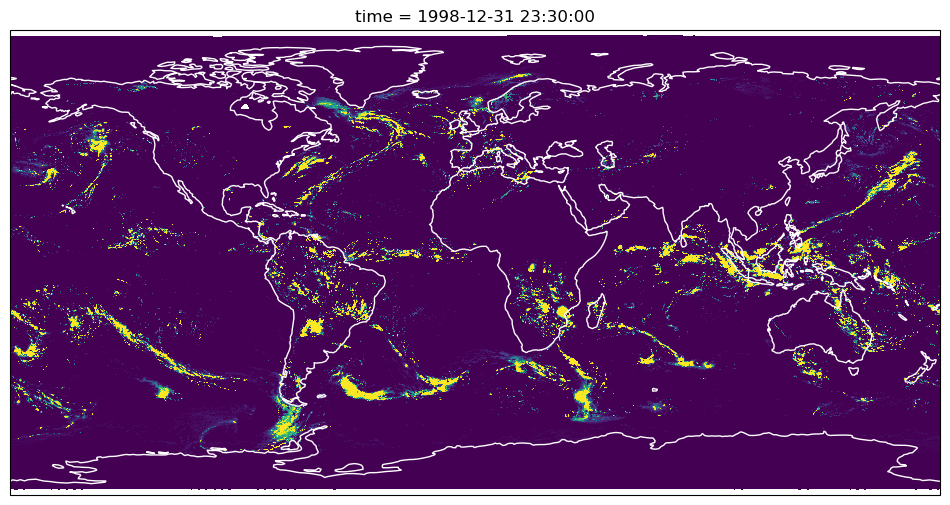

In [11]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

fix, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds.precipitation[-1].plot(robust=True, x="lon", ax=ax, add_colorbar=False)
ax.coastlines(color='w')
